In [1]:
from __future__ import print_function, division
import sys
sys.path.append('../')
import os
import os.path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import matplotlib.pyplot as plt
import time as t
import pandas as pd
from datetime import datetime


# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 # for image manipulation

import torch.utils.data as data
import glob
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import json

In [2]:
# Mean and std are as obtained from Autoencoder notebook,
cifar10_mean = [ 0.4732,  0.4637,  0.4293]
cifar10_std = [ 0.2202,  0.2168,  0.2153]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ]),
}

# Define dataloader

In [3]:
class Read_Dataset():
    
    def __init__(self, file_path,transform=None):
        self.data = pd.read_csv(file_path, sep = ',')
        self.label = self.data['class_label'].tolist() 
        self.image = [np.asarray(json.loads(x)) for x in self.data['img_data']]
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        label = self.label[index]
        image_tensor = torch.from_numpy(self.image[index].astype('float32'))
        image = transforms.ToPILImage()(image_tensor)
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

train_file_name = './modified_img_data.csv' 
test_file_name = './modified_img_data_test.csv'

train_val_list = ['train' , 'val']
path_to_input_file = {
    'train' : train_file_name ,
    'val':  test_file_name
    }

In [4]:
start = t.time()
image_datasets = {x: Read_Dataset( file_path = path_to_input_file[x], transform = data_transforms[x])
                  for x in train_val_list}
print("time taken for reading data sets : ", str(t.time() - start))

time taken for reading data sets :  80.89056324958801


In [5]:
batch_size_num = 64
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size_num, shuffle=True, num_workers=4)
              for x in train_val_list}

# Get latent encodings from the Trained Autoencoder

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # batch_size : 64
        # Input size to the Autoencoder : [batch_size, 3, 32, 32]
        # Output size from the Autoencoder : [batch_size, 3, 32, 32]
        self.encoder = nn.Sequential(
            # 3 input channels(RGB), 12 output channels, 3x3 square convolution
            nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 24, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 3, stride=2, padding=1), # Output size : [batch_size, 48, 16, 16]
            
        )
        self.decoder = nn.Sequential(
            # For Upscaling :
            # 2x2 kernels can only learn nearest pixel upscaling.
            # 3x3 kernels can do bilinear but will require asymmetric padding.
            # But 4x4 can do bilinear again without asymmetrical padding.
          
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # Output size: [batch_size, 24, 32, 32]
            nn.ReLU(),  #TODO : try with LeakyReLU while decoding
            nn.ConvTranspose2d(24, 12, 3, stride=1, padding=1), # Output size: [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 3, stride=1, padding=1), # Output size: [batch_size, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
def create_model():
    autoencoder = Autoencoder()
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU.")
    return autoencoder

In [8]:
# Create Autoencoder model
autoencoder = create_model()

print("Loading pretrained checkpoint...")
autoencoder.load_state_dict(torch.load("./weights/autoencoder_16*16.pkl"))

Model moved to GPU.
Loading pretrained checkpoint...


# Define and train the CNN classifier

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class CNN_classifier(nn.Module):
    def __init__(self):
        # Input size : [batch_size, 48, 16, 16]
        super(CNN_classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = 3, padding = 1) 
        self.conv1_bn = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(48)
        self.pool = nn.MaxPool2d(2, 2) # reduce the size to half.
        self.conv3 = nn.Conv2d(48, 48, kernel_size = 3, padding = 1)


        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
        
    # conv->relu->pool->batchnorm
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x) # Out size : [batch_size, 48, 8, 8]
        x = self.conv1_bn(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x) # Out size : [batch_size, 48, 4, 4]
        x = self.conv2_bn(x)
        
        x = F.dropout(F.relu(self.conv3(x)), p = 0.1)
        x = x.view(-1, 48 * 4 * 4)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


model = CNN_classifier()

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#Pls note that nn.CrossEntropyLoss() in pytorch is already implemented with Softmax. Softmax becomes necessary to bring values within range 0 to 1 before applying categorical cross entropy loss.# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
# optimizer = optim.Adadelta(self.model.parameters(), lr=1) #TODO: try with AdaDelta as well.

# Train the classifier network

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN_classifier(
  (conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
# Get Validation accuracy while training
def get_accuracy():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloders['val']:
            images, labels = data
            labels = labels.to(device)
            images = Variable(images.cuda())
            autoencoder_encodings, _ = autoencoder(images)
            outputs = model(autoencoder_encodings)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    return(100 * correct / total)

In [13]:
max_epoch = 100
running_loss = 0.0
best_epoch_accuracy = 0.0
for epoch in range(max_epoch):
    for i, data in enumerate(dataloders['train']):
        images, labels = data[0].to(device), data[1].to(device)
        images = Variable(images.cuda())

        autoencoder_encodings, _ = autoencoder(images)

        # zero the parameter gradients
        optimizer.zero_grad()


        # forward + backward + optimize
        outputs = model(autoencoder_encodings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
            
    # Print accuracy on validation set after each epoch
    epoch_accuracy = get_accuracy()
    print("epoch_accuracy : ", str(epoch_accuracy))
    # Save best model
    if(epoch_accuracy > best_epoch_accuracy):
        best_epoch_accuracy = epoch_accuracy
        print('Saving best Model...')
        if not os.path.exists('./weights'):
            os.mkdir('./weights')
        torch.save(model.state_dict(), "./weights/final_ensemble_cnn_classifier_dropout_batchnorm.pkl")
        
print('Finished Training')

[1,   100] loss: 1.645
[1,   200] loss: 1.337
[1,   300] loss: 1.232
[1,   400] loss: 1.126
[1,   500] loss: 1.114
[1,   600] loss: 1.065
Accuracy of the network on the 10000 test images: 62 %
epoch_accuracy :  62.42
Saving best Model...
[2,   100] loss: 1.842
[2,   200] loss: 0.941
[2,   300] loss: 0.941
[2,   400] loss: 0.909
[2,   500] loss: 0.856
[2,   600] loss: 0.862
Accuracy of the network on the 10000 test images: 67 %
epoch_accuracy :  67.72
Saving best Model...
[3,   100] loss: 1.564
[3,   200] loss: 0.805
[3,   300] loss: 0.811
[3,   400] loss: 0.782
[3,   500] loss: 0.813
[3,   600] loss: 0.802
Accuracy of the network on the 10000 test images: 69 %
epoch_accuracy :  69.89
Saving best Model...
[4,   100] loss: 1.392
[4,   200] loss: 0.731
[4,   300] loss: 0.720
[4,   400] loss: 0.752
[4,   500] loss: 0.746
[4,   600] loss: 0.716
Accuracy of the network on the 10000 test images: 70 %
epoch_accuracy :  70.55
Saving best Model...
[5,   100] loss: 1.300
[5,   200] loss: 0.685
[5

[37,   100] loss: 0.498
[37,   200] loss: 0.258
[37,   300] loss: 0.263
[37,   400] loss: 0.277
[37,   500] loss: 0.297
[37,   600] loss: 0.286
Accuracy of the network on the 10000 test images: 73 %
epoch_accuracy :  73.58
[38,   100] loss: 0.495
[38,   200] loss: 0.252
[38,   300] loss: 0.257
[38,   400] loss: 0.268
[38,   500] loss: 0.277
[38,   600] loss: 0.297
Accuracy of the network on the 10000 test images: 72 %
epoch_accuracy :  72.92
[39,   100] loss: 0.484
[39,   200] loss: 0.254
[39,   300] loss: 0.283
[39,   400] loss: 0.261
[39,   500] loss: 0.297
[39,   600] loss: 0.278
Accuracy of the network on the 10000 test images: 72 %
epoch_accuracy :  72.9
[40,   100] loss: 0.470
[40,   200] loss: 0.244
[40,   300] loss: 0.253
[40,   400] loss: 0.278
[40,   500] loss: 0.258
[40,   600] loss: 0.274
Accuracy of the network on the 10000 test images: 72 %
epoch_accuracy :  72.39
[41,   100] loss: 0.475
[41,   200] loss: 0.246
[41,   300] loss: 0.231
[41,   400] loss: 0.256
[41,   500] l

[74,   100] loss: 0.314
[74,   200] loss: 0.162
[74,   300] loss: 0.158
[74,   400] loss: 0.171
[74,   500] loss: 0.177
[74,   600] loss: 0.186
Accuracy of the network on the 10000 test images: 72 %
epoch_accuracy :  72.38
[75,   100] loss: 0.282
[75,   200] loss: 0.145
[75,   300] loss: 0.151
[75,   400] loss: 0.166
[75,   500] loss: 0.153
[75,   600] loss: 0.177
Accuracy of the network on the 10000 test images: 72 %
epoch_accuracy :  72.42
[76,   100] loss: 0.287
[76,   200] loss: 0.149
[76,   300] loss: 0.157
[76,   400] loss: 0.170
[76,   500] loss: 0.174
[76,   600] loss: 0.170
Accuracy of the network on the 10000 test images: 72 %
epoch_accuracy :  72.05
[77,   100] loss: 0.316
[77,   200] loss: 0.146
[77,   300] loss: 0.152
[77,   400] loss: 0.156
[77,   500] loss: 0.151
[77,   600] loss: 0.174
Accuracy of the network on the 10000 test images: 71 %
epoch_accuracy :  71.92
[78,   100] loss: 0.296
[78,   200] loss: 0.147
[78,   300] loss: 0.144
[78,   400] loss: 0.161
[78,   500] 

# Test the accuracy

In [14]:
# Get Validation accuracy

# Load the best model
path = "./weights/final_ensemble_cnn_classifier_dropout_batchnorm.pkl"
model = CNN_classifier()
state_dict = torch.load(path)
model.load_state_dict(state_dict)
model = model.to(device)
print(model)

correct = 0
total = 0
with torch.no_grad():
    for data in dataloders['val']:
        images, labels = data
        labels = labels.to(device)
        images = Variable(images.cuda())
        autoencoder_encodings, _ = autoencoder(images)
        outputs = model(autoencoder_encodings)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.3f %%' % (
    100 * correct / total))

CNN_classifier(
  (conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Accuracy of the network on the 10000 test images: 74.230 %


# Test the class wise accuracy


In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
y_actual = []
y_pred = []
with torch.no_grad():
    
    for data in dataloders['val']:
        images, labels = data
        y_actual.extend(labels.data.tolist())
        
        labels = labels.to(device)
        images = Variable(images.cuda())
        autoencoder_encodings, _ = autoencoder(images)
        outputs = model(autoencoder_encodings)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.data.tolist())
        
        c = (predicted == labels).squeeze()
        for i in range(int(labels.shape[0])):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 79 %
Accuracy of   car : 83 %
Accuracy of  bird : 63 %
Accuracy of   cat : 64 %
Accuracy of  deer : 68 %
Accuracy of   dog : 59 %
Accuracy of  frog : 81 %
Accuracy of horse : 79 %
Accuracy of  ship : 87 %
Accuracy of truck : 77 %


In [17]:
len(y_pred)

10000

In [18]:
len(y_actual)

10000

# Plot the confusion matrix

In [19]:
y_actual[0]

5

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns #For plotting
from sklearn.metrics import confusion_matrix
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [21]:
confm = confusion_matrix(y_actual, y_pred)
confm

array([[791,  12,  54,  20,  19,   4,  11,   9,  55,  25],
       [ 30, 835,   6,   6,   4,   1,   8,   4,  36,  70],
       [ 63,   7, 630,  70,  80,  49,  59,  28,   9,   5],
       [ 22,   6,  61, 640,  47, 108,  46,  39,  14,  17],
       [ 21,   1,  72,  79, 681,  29,  47,  59,   9,   2],
       [ 13,   3,  52, 214,  33, 591,  27,  47,   9,  11],
       [  6,   4,  33,  84,  32,  13, 813,   5,   5,   5],
       [ 15,   3,  29,  41,  55,  37,  13, 796,   2,   9],
       [ 68,  12,  14,   8,   5,   1,   2,   1, 870,  19],
       [ 41,  86,  12,  18,   5,   7,  14,   4,  34, 779]])

In [22]:
denominator = confm.sum(axis=1)
denominator[-1] = denominator[-1] + 1
confm = confm.astype('float') / denominator[:, np.newaxis]

Text(69,0.5,'true label')

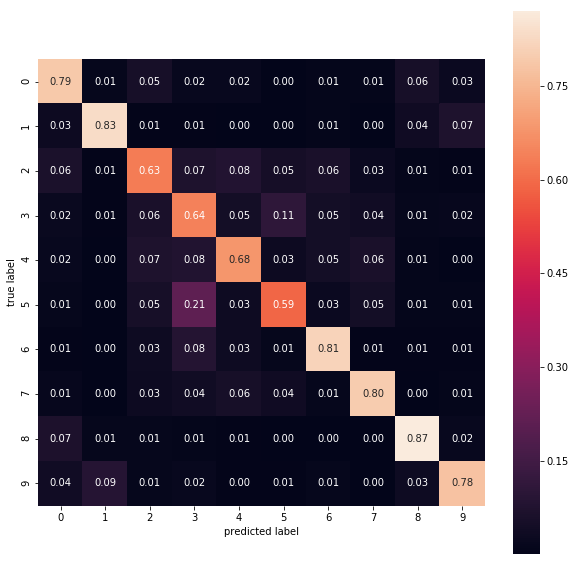

In [24]:
fig2=plt.figure(figsize=(10,10))
fig2.add_subplot(111)
sns.heatmap(confm,annot=True,square=True,cbar=True,fmt=".2f")
plt.xlabel("predicted label")
plt.ylabel("true label")